In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
temp = np.load('./data/t_test.npy')
rho = np.load('./data/rho_test.npy')

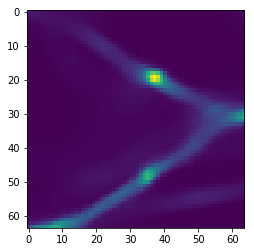

In [24]:
plt.imshow(rho[:,:,32])